In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

array([[         0,          0,          0,          0,         -1,
                -1,         -1,         -1,         -1,          0,
                -1, -100000000],
       [-100000000,         -1,          0,          0,          0,
                 0,         -1, -100000000,         -1,          0,
                 0,          0],
       [         0,          0,         -1,         -1,          0,
                 0,          0,         -1,         -1,         -1,
                 0,          0],
       [        -1,          0,          0,          0,          0,
                 0,          0, -100000000,         -1,          0,
                -1,         10]])

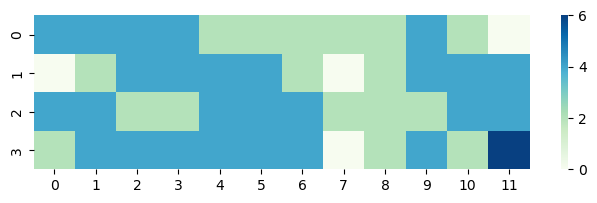

In [2]:
# 创建地图（包括低优先级区，无陷阱）
def init_map(x, y):
    ans = np.random.randint(0, 8, (x, y))//5*-1
    ans[x-1][y-1] = 10
    return ans


m = init_map(4, 12)

# 添加陷阱
def init_hole(m, num):
    for i in range(num):
        x = np.random.randint(0, m.shape[0])
        y = np.random.randint(0, m.shape[1])
        if x+y == 0 or x+y == m.shape[0]+m.shape[1]-2:
            continue
        m[x][y] = -1e8
    return m


m = init_hole(m, 5)
display(m)

# 绘图
mask = np.zeros(m.shape)
mask[np.where(m == -1e8)] = 1

dm = m.copy()
dm[np.where(m == 10)] = 6
dm[np.where(m == 0)] = 4
dm[np.where(m == -1)] = 2
dm[np.where(m == -1e8)] = 0
plt.figure(figsize=(8, 2))
sns.heatmap(dm, cmap="GnBu")
plt.show()

In [3]:
# 移动方向
delta_p = np.array(
    [[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1]]
)
gamma = 0.99

In [4]:
# 判断array是否在范围内
def in_range(array, left_top, right_botom):
    if left_top[0] <= array[0] < right_botom[0] and\
            left_top[1] <= array[1] < right_botom[1]:
        return True
    else:
        return False


class strategy_iteration:
    def __init__(self, m, gamma) -> None:
        self.strategy = np.zeros(m.shape, dtype=np.int32)
        self.v = np.zeros(m.shape)
        self.m = m
        self.gamma = gamma
        return

    # 策略评估
    def cal_V(self) -> None:
        tmp = np.zeros(self.m.shape)
        delta = 1e9
        z = 1e-6  # 迭代阈值

        while delta > z:
            for i in range(tmp.shape[0]):
                for j in range(tmp.shape[1]):
                    nexts = np.array([i, j])+delta_p[self.strategy[i][j]]
                    if not in_range(nexts, [0, 0], tmp.shape):
                        tmp[i][j] = -1e8
                    # 若出界，认为该状态价值为-1e8
                    else:
                        tmp[i][j] = self.m[nexts[0]][nexts[1]] +\
                            self.gamma*self.v[nexts[0]][nexts[1]]
            delta = np.linalg.norm(x=tmp-self.v, ord=1)
            self.v = tmp.copy()
        return

    # 策略选择
    def update_strategy(self) -> None:
        for i in range(self.strategy.shape[0]):
            for j in range(self.strategy.shape[1]):
                len = delta_p.shape[0]
                values = np.zeros(len)
                for k in range(len):
                    nexts = np.array([i, j])+delta_p[k]
                    if not in_range(nexts, [0, 0], self.strategy.shape):
                        values[k] = -1e8
                    else:
                        values[k] = self.m[nexts[0]][nexts[1]] +\
                            self.gamma*self.v[nexts[0]][nexts[1]]

                # 选择最大价值动作，这里判断当前策略是否为最优策略之一，防止震荡
                if not self.strategy[i][j] in np.where(values == np.max(values))[0]:
                    self.strategy[i][j] = np.where(
                        values == np.max(values))[0][0]
        return


k = strategy_iteration(m, gamma)
tmp = np.zeros(k.v.shape)
delta = 1e9

# 迭代直到收敛
while delta > 0:
    k.cal_V()
    k.update_strategy()
    delta = np.linalg.norm(tmp-k.v, ord=1)
    tmp = k.v.copy()

In [5]:
def show(arrays):
    u = arrays[:, :, 1]
    v = arrays[:, :, 0]
    x = np.array([range(arrays.shape[1]) for i in range(arrays.shape[0])])+0.5
    y = np.array([[i for j in range(arrays.shape[1])]
                 for i in range(arrays.shape[0])])+0.5

    plt.figure(figsize=(8, 2))

    plt.xticks(np.linspace(0, arrays.shape[1]-1, arrays.shape[1]))
    plt.yticks(np.linspace(0, arrays.shape[0]-1, arrays.shape[0]))
    plt.grid(zorder=0)

    # 绘制箭头图
    plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=2, zorder=1)
    sns.heatmap(dm, cmap="GnBu", zorder=0)
    plt.xlim(0, arrays.shape[1])
    plt.ylim(0, arrays.shape[0])

    ax = plt.gca()
    ax.invert_yaxis()
    # 显示图形
    plt.show()

array([[4, 4, 4, 2, 2, 2, 4, 4, 4, 2, 2, 2],
       [4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 2],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 0]])

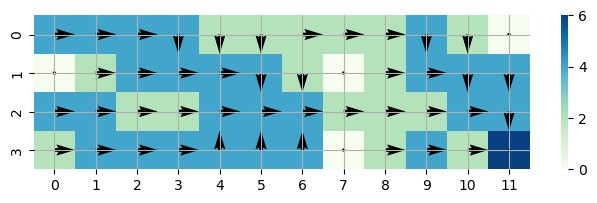

In [6]:
strategy = k.strategy
# int -> array
ans = np.zeros((strategy.shape[0], strategy.shape[1], 2))
for i in range(strategy.shape[0]):
    for j in range(strategy.shape[1]):
        if mask[i][j]:
            ans[i][j] = np.array([0, 0])
        else:
            ans[i][j] = delta_p[strategy[i][j]]

display(strategy)
show(ans)

In [7]:
class value_iteration:
    def __init__(self, m, gamma) -> None:
        self.strategy = np.zeros(m.shape, dtype=np.int32)
        self.v = np.zeros(m.shape)
        self.m = m
        self.gamma = gamma
        return

    def update(self):
        tmp = np.zeros(self.m.shape)
        delta = 1e9
        z = 1e-6  # 迭代阈值

        while delta > z:
            for i in range(self.m.shape[0]):
                for j in range(self.m.shape[1]):
                    len = delta_p.shape[0]
                    values = np.zeros(len)
                    for k in range(len):
                        nexts = np.array([i, j])+delta_p[k]
                        if not in_range(nexts, [0, 0], self.m.shape):
                            values[k] = -1e8
                        else:
                            values[k] = self.v[nexts[0]][nexts[1]]
                    tmp[i][j] = self.m[i][j]+self.gamma*max(values)
            delta = np.linalg.norm(tmp-self.v, ord=1)
            self.v = tmp.copy()
        return

    # 策略贪心选择
    def get_strategy(self):
        for i in range(self.m.shape[0]):
            for j in range(self.m.shape[1]):
                len = delta_p.shape[0]
                values = np.zeros(len)
                for k in range(len):
                    nexts = np.array([i, j])+delta_p[k]
                    if not in_range(nexts, [0, 0], self.strategy.shape):
                        values[k] = -1e8
                    else:
                        values[k] = self.v[nexts[0]][nexts[1]]
                self.strategy[i][j] = np.where(values == max(values))[0][0]
        return


vk = value_iteration(m, gamma)
vk.update()
vk.get_strategy()
vk.strategy

array([[4, 4, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2],
       [4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 2, 2],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 0]])

array([[4, 4, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2],
       [4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 2, 2],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 0]])

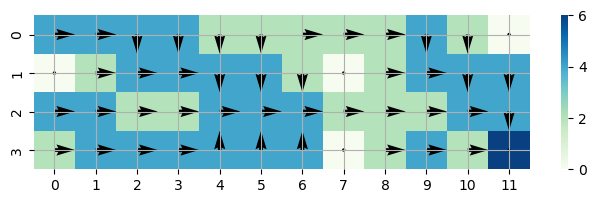

In [8]:
strategy = vk.strategy
ans = np.zeros((strategy.shape[0], strategy.shape[1], 2))
for i in range(strategy.shape[0]):
    for j in range(strategy.shape[1]):
        if mask[i][j]:
            ans[i][j] = np.array([0, 0])
        else:
            ans[i][j] = delta_p[strategy[i][j]]

display(strategy)
show(ans)